['UNKNOWN', 'NON-SMOKER', 'PAST SMOKER', 'CURRENT SMOKER']
Size of df_train = 24
Size of df_val = 16


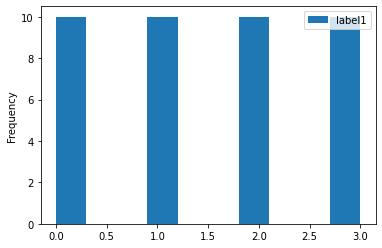

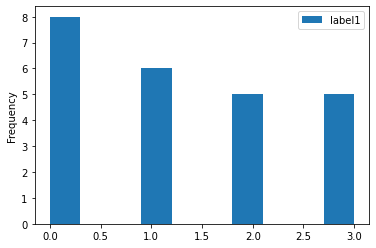

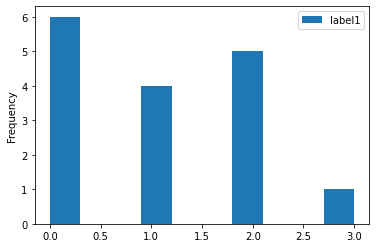

In [1]:
import os
import pandas as pd
import numpy as np

PATH = os.path.abspath(os.getcwd())
datasetPath = PATH+"/Case_Presentation/"
TraindatasetPath = datasetPath+"train/"
TestdatasetPath = datasetPath+"test/"

#Make Label file
FileList = os.listdir(TraindatasetPath)
ClassName = []

for i in range(len(FileList)):
    if FileList[i] != 'train.csv' and FileList[i] != 'classes.txt' and FileList[i] != '.ipynb_checkpoints':
        tmpName = FileList[i].split("_",1)[0]
        try:
            ClassName.index(tmpName)
        except :
            ClassName.append(tmpName)
        
print(ClassName)

file = open(datasetPath+'classes.txt','w');
for i in range(len(ClassName)):
    file.write(str(ClassName[i])+'\n');
file.close();

#Creat Training file
CLASSNAME = []
CLASSNAMES = []
INFO = []
FileList = os.listdir(TraindatasetPath)


for i in range(len(FileList)):
    filename = FileList[i]
    tmpName = filename.split("_",1)[0]
    classN = ClassName.index(tmpName)
    try:
        classN = ClassName.index(tmpName)
        CLASSNAMES.append(tmpName)
        CLASSNAME.append(classN)
    
        file = open(TraindatasetPath+filename,'r')
        info = file.read()
        file.close()
        INFO.append(info)
        
    except :
        print("except {}".format(tmpName))
    

df = pd.DataFrame({'label1':CLASSNAME,'label2':CLASSNAMES,'text':INFO})
df.plot.hist()

DFSIZE = df.index.size

REPLACE=False
ratio = 0.6
ratio_tr = int(ratio*DFSIZE)
ratio_val = DFSIZE-ratio_tr

df_train = df.sample(n=ratio_tr, replace=REPLACE)
df_val = df.sample(n=ratio_val, replace=REPLACE)

df_train.plot.hist()
df_val.plot.hist()
print("Size of df_train = {}".format(df_train.index.size))
print("Size of df_val = {}".format(df_val.index.size))

df_train.to_csv(datasetPath+"train.csv",index=False,sep=',',header=False)
df_val.to_csv(datasetPath+"val.csv",index=False,sep=',',header=False)


#Creat Testing file
CLASSNAME = []
CLASSNAMES = []
INFO = []
FileList = os.listdir(TestdatasetPath)


for i in range(len(FileList)):
    filename = FileList[i]    
    tmpName = filename.split("_",1)[0]
    
    CLASSNAME.append(0)
    CLASSNAMES.append(ClassName[0])
    
    file = open(TestdatasetPath+filename,'r')
    info = file.read()
    file.close()
    INFO.append(info)
        
import pandas as pd
df_test = pd.DataFrame({'label1':CLASSNAME,'label2':CLASSNAMES,'text':INFO})
df_test.to_csv(datasetPath+"test.csv",index=False,sep=',',header=False)


In [2]:
import logging
import torch
import io
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from tqdm import tqdm

URLS = {
    'Smoking_Status':
        'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms'
}


def _csv_iterator(data_path, ngrams, yield_cls=False):
    tokenizer = get_tokenizer("basic_english")
    with io.open(data_path, encoding="utf8") as f:
        reader = unicode_csv_reader(f)
        for row in reader:
            tokens = ' '.join(row[1:])
            tokens = tokenizer(tokens)
            if yield_cls:
                #yield int(row[0]) - 1, ngrams_iterator(tokens, ngrams)
                yield int(row[0]), ngrams_iterator(tokens, ngrams)
            else:
                yield ngrams_iterator(tokens, ngrams)


def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token]
                                        for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)


class TextClassificationDataset(torch.utils.data.Dataset):
    """Defines an abstract text classification datasets.
       Currently, we only support the following datasets:
             - AG_NEWS
             - SogouNews
             - DBpedia
             - YelpReviewPolarity
             - YelpReviewFull
             - YahooAnswers
             - AmazonReviewPolarity
             - AmazonReviewFull
    """

    def __init__(self, vocab, data, labels):
        """Initiate text-classification dataset.
        Arguments:
            vocab: Vocabulary object used for dataset.
            data: a list of label/tokens tuple. tokens are a tensor after
                numericalizing the string tokens. label is an integer.
                [(label1, tokens1), (label2, tokens2), (label2, tokens3)]
            label: a set of the labels.
                {label1, label2}
        Examples:
            See the examples in examples/text_classification/
        """

        super(TextClassificationDataset, self).__init__()
        self._data = data
        self._labels = labels
        self._vocab = vocab

    def __getitem__(self, i):
        return self._data[i]

    def __len__(self):
        return len(self._data)

    def __iter__(self):
        for x in self._data:
            yield x

    def get_labels(self):
        return self._labels

    def get_vocab(self):
        return self._vocab


def _setup_datasets(dataset_name, root='.data', ngrams=1, vocab=None, include_unk=False):
    #dataset_tar = download_from_url(URLS[dataset_name], root=root)
    #extracted_files = extract_archive(dataset_tar)
    rootPath =root
    extracted_files = [rootPath+'train.csv',rootPath+'test.csv',rootPath+'classes.txt',rootPath+'readme.txt',rootPath+'val.csv']   
    for fname in extracted_files:
        if fname.endswith('train.csv'):
            train_csv_path = fname
        #if fname.endswith('test.csv'):
        if fname.endswith('val.csv'):    
            test_csv_path = fname

    if vocab is None:
        print('Building Vocab based on {}'.format(train_csv_path))
        vocab = build_vocab_from_iterator(_csv_iterator(train_csv_path, ngrams))
    else:
        if not isinstance(vocab, Vocab):
            raise TypeError("Passed vocabulary is not of type Vocab")
    print('Vocab has {} entries'.format(len(vocab)))
    
    print('Creating training data')
    train_data, train_labels = _create_data_from_iterator(
        vocab, _csv_iterator(train_csv_path, ngrams, yield_cls=True), include_unk)
    
    print('Creating val data')
    test_data, test_labels = _create_data_from_iterator(
        vocab, _csv_iterator(test_csv_path, ngrams, yield_cls=True), include_unk)
    
    
    print(train_labels)
    print(test_labels)
    
   
    if len(train_labels ^ test_labels) > 0:
        raise ValueError("Training and val labels don't match")
    return (TextClassificationDataset(vocab, train_data, train_labels),
            TextClassificationDataset(vocab, test_data, test_labels))


def Smoking_Status(*args, **kwargs):
    """ Defines Smoking_Status datasets.
        The labels includes:
            - 0 : UNKNOWN
            - 1 : NON-SMOKER
            - 2 : PAST SMOKER
            - 3 : CURRENT SMOKER
    Create supervised learning dataset: Smoking_Status
    Separately returns the training and test dataset
    Arguments:
        root: Directory where the datasets are saved. Default: ".data"
        ngrams: a contiguous sequence of n items from s string text.
            Default: 1
        vocab: Vocabulary used for dataset. If None, it will generate a new
            vocabulary based on the train data set.
        include_unk: include unknown token in the data (Default: False)
    Examples:
        >>> train_dataset, test_dataset = torchtext.datasets.Smoking_Status(ngrams=3)
    """

    return _setup_datasets(*(("Smoking_Status",) + args), **kwargs)


DATASETS = {
    'Smoking_Status': Smoking_Status
}


LABELS = {
    'Smoking_Status': {0: 'UNKNOWN',
                1: 'NON-SMOKER',
                2: 'PAST SMOKER',
                3: 'CURRENT SMOKER'}
}


In [3]:
import os
import torch
import torchtext

NGRAMS = 2
PATH = os.path.abspath(os.getcwd())
datasetPath = PATH+"/Case_Presentation/"
TraindatasetPath = datasetPath+"train/"
TestdatasetPath = datasetPath+"test/"

# if not os.path.isdir(datasetPath+'NLPdata'):
#     os.mkdir(datasetPath+'NLPdata')
train_dataset, test_dataset = DATASETS['Smoking_Status'](
    root=datasetPath, ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

24lines [00:00, 2348.76lines/s]
24lines [00:00, 1305.92lines/s]
16lines [00:00, 1387.81lines/s]

Building Vocab based on /home/kevin7674/mingta/hw1/Smoking_Status_Detection/Case_Presentation/train.csv
Vocab has 8647 entries
Creating training data
Creating val data
{0, 1, 2, 3}
{0, 1, 2, 3}


In [4]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [5]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)
# print(train_dataset.__getitem__(0))
# print(train_dataset.get_labels())
# print(train_dataset.get_vocab())

In [6]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label


In [7]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        print(offsets)
        #print(output)
        print(cls)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)



import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 50
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])


TrLOSS = []
TrACC = []
ValLOSS = []
ValACC = []

TOPACC = 0
TOPInfo = ""

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    TrLOSS.append(train_loss)
    TrACC.append(train_acc * 100)
    ValLOSS.append(valid_loss)
    ValACC.append(valid_acc * 100)
    if train_acc * 100 > TOPACC :
        TOPACC = train_acc * 100
        torch.save(model, 'Bestmodel.pkl')
        TOPInfo = "tr_acc={} val_acc={}".format(TOPACC,valid_acc * 100)
        
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')


tensor([    0,   805,  2200,  2829,  3630,  4275,  5090,  5903,  7052,  7389,
         8212,  8527, 10046, 10593, 11416, 11673], device='cuda:0')
tensor([0, 3, 1, 2, 3, 0, 3, 2, 0, 2, 0, 1, 3, 1, 0, 2], device='cuda:0')
tensor([   0,  335,  652, 1745, 2950, 4341], device='cuda:0')
tensor([0, 2, 1, 1, 1, 0], device='cuda:0')
Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.1284(train)	|	Acc: 22.7%(train)
	Loss: 1.9657(valid)	|	Acc: 0.0%(valid)
tensor([    0,   645,  1460,  1717,  2346,  3169,  4318,  5523,  6328,  6645,
         7446,  8539, 10058, 11315, 11650, 11965], device='cuda:0')
tensor([3, 0, 0, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 0, 0, 3], device='cuda:0')
tensor([   0,  691, 2082, 2629, 2966, 3789], device='cuda:0')
tensor([0, 1, 3, 0, 2, 3], device='cuda:0')
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.1347(train)	|	Acc: 31.8%(train)
	Loss: 1.1990(valid)	|	Acc: 50.0%(valid)
tensor([    0,   315,  1834,  2639,  3186,  4443,  5134,  6529,  6846,  7475,
         8866, 10071, 108

tensor([    0,   805,  1062,  2319,  2634,  3783,  4598,  5421,  6066,  7457,
         8086,  8423,  9236, 10037, 10860, 11953], device='cuda:0')
tensor([0, 0, 2, 0, 2, 0, 2, 3, 1, 1, 0, 3, 2, 1, 1, 2], device='cuda:0')
tensor([   0, 1395, 2600, 2935, 3626, 4173], device='cuda:0')
tensor([3, 1, 0, 0, 3, 1], device='cuda:0')
Epoch: 39  | time in 0 minutes, 0 seconds
	Loss: 0.1191(train)	|	Acc: 54.5%(train)
	Loss: 1.4026(valid)	|	Acc: 50.0%(valid)
tensor([    0,   691,  1336,  2541,  2858,  3671,  3928,  4729,  5064,  6157,
         6472,  7991,  8806, 10063, 11212, 11549], device='cuda:0')
tensor([0, 3, 1, 2, 3, 0, 2, 0, 1, 0, 1, 0, 2, 2, 0, 0], device='cuda:0')
tensor([   0, 1391, 2786, 3333, 4156, 4785], device='cuda:0')
tensor([1, 3, 3, 1, 1, 2], device='cuda:0')
Epoch: 40  | time in 0 minutes, 0 seconds
	Loss: 0.1203(train)	|	Acc: 54.5%(train)
	Loss: 1.4035(valid)	|	Acc: 50.0%(valid)
tensor([    0,   645,  1468,  2725,  3530,  4221,  4558,  5373,  6174,  7379,
         7694,  8029, 

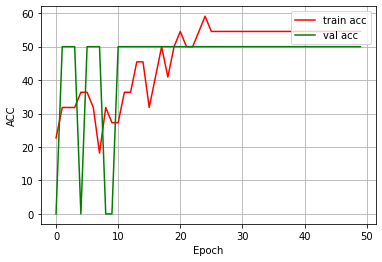

Best ACC = tr_acc=59.09090909090909 val_acc=50.0


<Figure size 432x288 with 0 Axes>

In [8]:
# print(TrLOSS)
# print(TrACC)
# print(ValLOSS)
# print(ValACC)
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def Draw(dataA,Alabel,dataB,Blabel,labely):
    plt.plot(dataA, 'r', label=Alabel)
    plt.plot(dataB, 'g', label=Blabel)
    plt.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel(labely)
    plt.legend(loc="upper right")
    plt.show()
    plt.figure()
    
Draw(TrACC,'train acc',ValACC,'val acc','ACC')    
print("Best ACC = "+str(TOPInfo))

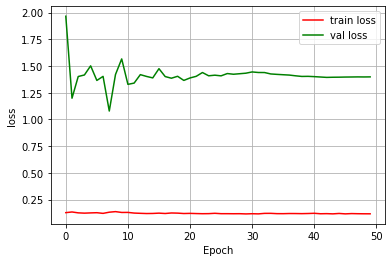

<Figure size 432x288 with 0 Axes>

In [9]:
Draw(TrLOSS,'train loss',ValLOSS,'val loss','loss')  